# **Base Covid-19 Spread Model**

Goal: simulate virus spread in a population. Agents will move randomly on an on-lattice grid and infected individuals have the ability to spread infection to susceptible individuals.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

**Things to add from here:**
-determining different agents

-is there a way to import a map into the model

-making directed movement (we create centoids like residential areas, grocery stores, lecture halls, different schools,

-give each agent age + pre-existing conditions

-encode an "incubation" period

-encode the ability to get better after infection

-encode death of agents

-maybe encode "health" as a 

-social distancing/self-quaranting based on whether they know they are infected

-encode known and unknwon infections --> based on who is getting tested

In [2]:
import skimage
import skimage.io
import skimage.viewer
import skimage.color
from skimage.measure import label, regionprops, regionprops_table


/usr/local/lib/python3.7/site-packages/skimage/viewer/utils/__init__.py:1: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  from .core import *


In [3]:
# from mesa import Agent, Model
# from mesa.time import RandomActivation
# from mesa.space import MultiGrid
# from mesa.datacollection import DataCollector

# class Individual(Agent):
#     def __init__(self,unique_id,model,infected):
#         super().__init__(unique_id,model)
#         self.infected = infected
#     #instantiate private variables like age, pre-existing conditions...
  
#     def step(self):
#         self.move()
#         if self.infected == 1:
#             self.infect()

#     def move(self):
#         move_spots = self.model.grid.get_neighborhood(
#             self.pos,
#             moore = True,
#             include_center=False
#         )
#         new_position = self.random.choice(move_spots)
#         self.model.grid.move_agent(self,new_position)

#     def infect(self):
#         infectable_individuals = self.model.grid.get_cell_list_contents([self.pos])
#         if len(infectable_individuals) > 1:
#             for a in infectable_individuals:
#                 a.infected = 1

# class CovidModel(Model):
#     def __init__(self,N,width,height):
#         super().__init__()
#         self.num_agents = N
#         self.grid = MultiGrid(width,height,True)
#         self.schedule = RandomActivation(self)

#         for i in range(self.num_agents):
#             infected_i = np.random.randint(0,2)
#             a = Individual(i,self,infected_i)
#             self.schedule.add(a)

#             x = self.random.randrange(self.grid.width)
#             y = self.random.randrange(self.grid.height)
# #             print(x)
# #             print(y)
#             self.grid.place_agent(a,(x,y))

#         self.datacollector = DataCollector(
#           model_reporters = {"Number_Infected": calc_num_infected},
#           agent_reporters = {"Infection_Status": "infected"}
#         )
  
#     def step(self):
#         self.datacollector.collect(self)
#         self.schedule.step()

# def calc_num_infected(model):
#     return sum(a.infected for a in model.schedule.agents)

In [3]:
# Global Variables:
job_list = ["Thornton","Rotunda","UVA Health","Nau Hall","Minor Hall","Mcintire"]
house_list = ["McCormick","Alderman","Dungle-Jungle","Gooch-Dillard"]
leisure_list = ["Clem","Clark","Corner","Mad Bowl"]
locations = {'Thornton': [7,9], 'Rotunda': [14,5], 'UVA Health': [16,12], 'Nau Hall': [13,11], 'Minor Hall': [12,8], 'Mcintire': [14,10]}
leisure = {'Clem':[11,5],'Clark':[10,8],'Corner': [15,6],'Mad Bowl':[14,3]}
houses = {'McCormick':[6,6],"Alderman":[3,8],"Dungle-Jungle":[1,10], "Gooch-Dillard":[1,1]}
# make these coordinates accurate
density_threshold = 178/2500;
mask_advantage = 0.1
all_infected = 0 
time = 0;
prob_infection = 1-0.8
prob_recovery = 0.68

In [8]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
from scipy.spatial import distance
import matplotlib.pyplot as plt

# job_list = ["Thornton","Rotunda","UVA Health","Nau Hall","Minor Hall","Mcintire","Newcomb Hall"]
# house_list = ["McCormick","Alderman","Dungle-Jungle","Gooch-Dillard"]
# leisure_list = ["Clem","Clark","Corner","Mad Bowl"]
# locations = {'Thornton': [7,9], 'Rotunda': [14,5], 'UVA Health': [16,12], 'Nau Hall': [13,11], 'Minor Hall': [12,8], 'Mcintire': [14,10]}
# leisure = {'Clem':[11,5],'Clark':[10,8],'Corner': [15,6],'Mad Bowl':[14,3]}
# houses = {'McCormick':[6,6],"Alderman":[3,8],"Dungle-Jungle":[1,10], "Gooch-Dillard":[1,1]}
# # make these coordinates accurate
# density_threshold = 178/2500;
# mask_advantage = 0.1
# all_infected = 0 
# time = 0;
# prob_infection = 1-0.8
# prob_recovery = 0.68

class Individual(Agent):
  #age,health,job
    def __init__(self,unique_id,model,infected,house,mask,responsible): # incubation period? 
        super().__init__(unique_id,model)

        # list of jobs students can have and the probability they are that student
        self.infected = infected
        self.job = np.random.choice(job_list)
        self.home = house
        if self.infected == 0:
            self.time_infected = 0
        else:
            self.time_infected = -1
        #instantiate private variables like age, pre-existing conditions...
        self.mask = mask
        self.responsible = responsible
  
    def step(self):
        self.move()
        if self.infected == 1:
            self.infect()
            self.time_infected = self.time_infected + 1;
            self.recover()
    
    def move(self):
#         move_spots = self.model.grid.get_neighborhood(
#             self.pos,
#             moore = True,
#             include_center = False
#         )
#         new_position_i = np.random.randint(0,8)
#         new_position = move_spots[new_position_i]
#         self.model.grid.move_agent(self, new_position)
        neighbors = self.model.grid.get_neighborhood(self.pos, moore = True, include_center = False)
        #not sure what we wanna do w/ the grid size. Grounds is 1.8 miles^2 = ~50 mil ft^2. if each patch is 100x100 ft, we have 5000 patches
        grid_size = 5000 #100 ft x 100 ft patch (is that too big?)
        densities = []
        dictionary = {}
        
        if (self.model.time % 96) < 40:
            destination = tuple([k*6 for k in houses[self.home]])
        if (self.model.time % 96) >= 40 and (self.model.time%96) < 56:
#             print("im here")
            destination = tuple([k*6 for k in locations[self.job]])
        if (self.model.time % 96) >= 56 and (self.model.time%96) < 72:
            destination = tuple([k*6 for k in houses[self.home]])
        if (self.model.time % 96) >= 72:
            l = np.random.choice(leisure_list)
            destination = tuple([k*6 for k in leisure[l]])
            
        distances = [distance.euclidean(i,destination) for i in neighbors]
#         new_position = neighbors[np.argmin(distances)]
#         self.model.grid.move_agent(self, new_position)      
        densities = [len(self.model.grid.get_cell_list_contents([n])) / grid_size for n in neighbors]
#         print(densities)
        viable_patches = [i < density_threshold for i in densities]
        # filtered_list = [i for (i, v) in zip(distances, viable_patches) if v ]
        min_index = 0
        if sum(viable_patches) > 0:
            for i in range(len(distances)):
                if viable_patches[i] ==  True and distances[i] < distances[min_index]:
                    min_index = i;
            min_index
        else:
            if responsible == 1:
                min_index = np.argmin(densities)
            else:
                min_index = np.argmin(distances)
        new_position = neighbors[min_index]
        self.model.grid.move_agent(self, new_position)
        
    def infect(self):
#         print("im here")
        num_mask = 0;
        num_infected = 0;
        if self.infected == 1:
            people = self.model.grid.get_cell_list_contents([self.pos])
            density = len(people) / 5000
            for i in people:
                p = np.random.random()
                if i.infected == 0:
                    if (self.model.time % 96) < 40 and p < 0.05:
                        i.infected = 1
                        i.time_infected = 0
                    if (self.model.time % 96) >= 40 and (self.model.time%96) < 56 and p < 0.1:
                        i.infected = 1
                        i.time_infected = 0
                    if (self.model.time % 96) >= 56 and (self.model.time%96) < 72 and p < 0.05:
                        i.infected = 1
                        i.time_infected = 0
                    if (self.model.time % 96) >= 72 and p < 0.5:
                        i.infected = 1
                        i.time_infected = 0


#             for i in people:
#                 if i.infected == 1:
#                     num_infected = num_infected + 1   
#                 if i.mask == 1:
#                     num_mask = num_mask + 1
#             num_susceptible = len(people) - num_infected

    def recover(self):
        p = np.random.random()
#         print("here")
        if self.infected == 1:
#             if (self.time_infected / 24) > 10:
            if p < prob_recovery:
#                 print("recovrerd!")
                self.infected = 0;
                self.time_infected = -1
        

class CovidModel(Model):
    def __init__(self,N,width,height,initial_infected,p_mask, p_responsible):
        super().__init__()
        self.num_agents = N
        self.grid = MultiGrid(width,height,True)
        self.schedule = RandomActivation(self)
        self.time = 0
        
        for i in range(N):
            p = np.random.random()
            mask_i = 0;
            responsible_i = 0;
            infected_i = 0;
            
            if p < p_mask:
                mask_i = 1;
            if p < p_responsible:
                responsible_i = 1;
            if i < initial_infected:
                infected_i = 1
            
            house_i = np.random.choice(house_list)
            
            a = Individual(i,self,infected_i, house_i, mask_i,responsible_i)
            self.schedule.add(a)
            
#             x = self.random.randrange(self.grid.width)
#             y = self.random.randrange(self.grid.height)
#             print(houses[house_i])
            loc = tuple([k*6 for k in houses[house_i]])
            self.grid.place_agent(a,(loc))
            
        self.datacollector = DataCollector(
          model_reporters = {"Number_Infected": calc_num_infected},
          agent_reporters = {"Infection_Status": "infected"}
        )
        print("finished")
   
    def step(self):
        self.schedule.step()
        self.time = self.time + 1
        self.datacollector.collect(self)
        

def calc_num_infected(model):
    return sum(a.infected for a in model.schedule.agents)

In [9]:
model = CovidModel(4000, 100, 100,100,.8,.8)
for i in range(1000):
    model.step()

finished


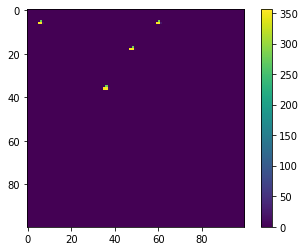

In [12]:
import numpy as np

agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
plt.imshow(agent_counts,interpolation='nearest')
plt.colorbar()

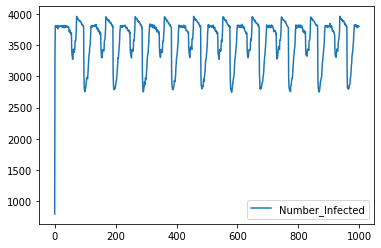

In [11]:
num_infected_overtime = model.datacollector.get_model_vars_dataframe()
num_infected_overtime.plot()

In [ ]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
from scipy.spatial import distance
import matplotlib.pyplot as plt

# job_list = ["Thornton","Rotunda","UVA Health","Nau Hall","Minor Hall","Mcintire","Newcomb Hall"]
# house_list = ["McCormick","Alderman","Dungle-Jungle","Gooch-Dillard"]
# leisure_list = ["Clem","Clark","Corner","Mad Bowl"]
# locations = {'Thornton': [7,9], 'Rotunda': [14,5], 'UVA Health': [16,12], 'Nau Hall': [13,11], 'Minor Hall': [12,8], 'Mcintire': [14,10]}
# leisure = {'Clem':[11,5],'Clark':[10,8],'Corner': [15,6],'Mad Bowl':[14,3]}
# houses = {'McCormick':[6,6],"Alderman":[3,8],"Dungle-Jungle":[1,10], "Gooch-Dillard":[1,1]}
# # make these coordinates accurate
# density_threshold = 178/2500;
# mask_advantage = 0.1
# all_infected = 0 
# time = 0;
# prob_infection = 1-0.8
# prob_recovery = 0.68

class Individual(Agent):
  #age,health,job
    def __init__(self,unique_id,model,infected,house,mask,responsible): # incubation period? 
        super().__init__(unique_id,model)

        # list of jobs students can have and the probability they are that student
        self.infected = infected
        self.job = np.random.choice(job_list)
        self.home = house
        if self.infected == 0:
            self.time_infected = 0
        else:
            self.time_infected = -1
        #instantiate private variables like age, pre-existing conditions...
        self.mask = mask
        self.responsible = responsible
  
    def step(self):
        self.move()
        if self.infected == 1:
            self.time_infected = self.time_infected + 1;
            if self.time_infected > 48 and self.time_infected < 480:
                self.infect()
            self.recover()

#             self.infect()
#             self.time_infected = self.time_infected + 1;
#             self.recover()
    
    def move(self):
#         move_spots = self.model.grid.get_neighborhood(
#             self.pos,
#             moore = True,
#             include_center = False
#         )
#         new_position_i = np.random.randint(0,8)
#         new_position = move_spots[new_position_i]
#         self.model.grid.move_agent(self, new_position)
        neighbors = self.model.grid.get_neighborhood(self.pos, moore = True, include_center = False)
        #not sure what we wanna do w/ the grid size. Grounds is 1.8 miles^2 = ~50 mil ft^2. if each patch is 100x100 ft, we have 5000 patches
        grid_size = 5000 #100 ft x 100 ft patch (is that too big?)
        densities = []
        dictionary = {}
        
        if self.infected == 0:
            if (self.model.time % 96) < 40:
                destination = tuple([k*6 for k in houses[self.home]])
            if (self.model.time % 96) >= 40 and (self.model.time%96) < 56:
    #             print("im here")
                destination = tuple([k*6 for k in locations[self.job]])
            if (self.model.time % 96) >= 56 and (self.model.time%96) < 72:
                destination = tuple([k*6 for k in houses[self.home]])
            if (self.model.time % 96) >= 72:
                l = np.random.choice(leisure_list)
                destination = tuple([k*6 for k in leisure[l]])
                
        p = np.random.random()
        if self.infected == 1:
            if p < 0.8:
                destination = (18,53)
            else:
                destination = tuple([k*6 for k in houses[self.home]])
            
        distances = [distance.euclidean(i,destination) for i in neighbors]
#         new_position = neighbors[np.argmin(distances)]
#         self.model.grid.move_agent(self, new_position)      
        densities = [len(self.model.grid.get_cell_list_contents([n])) / grid_size for n in neighbors]
#         print(densities)
        viable_patches = [i < density_threshold for i in densities]
        # filtered_list = [i for (i, v) in zip(distances, viable_patches) if v ]
        min_index = 0
        if sum(viable_patches) > 0:
            for i in range(len(distances)):
                if viable_patches[i] ==  True and distances[i] < distances[min_index]:
                    min_index = i;
            min_index
        else:
            if responsible == 1:
                min_index = np.argmin(densities)
            else:
                min_index = np.argmin(distances)
        new_position = neighbors[min_index]
        self.model.grid.move_agent(self, new_position)
        
    def infect(self):
#         print("im here")
        num_mask = 0;
        num_infected = 0;
        if self.infected == 1:
            people = self.model.grid.get_cell_list_contents([self.pos])
            density = len(people) / 5000
            for i in people:
                p = np.random.random()
                if i.infected == 0:
                    if (self.model.time % 96) < 40 and p < 0.05:
                        i.infected = 1
                        i.time_infected = 0
                    if (self.model.time % 96) >= 40 and (self.model.time%96) < 56 and p < 0.1:
                        i.infected = 1
                        i.time_infected = 0
                    if (self.model.time % 96) >= 56 and (self.model.time%96) < 72 and p < 0.05:
                        i.infected = 1
                        i.time_infected = 0
                    if (self.model.time % 96) >= 72 and p < 0.5:
                        i.infected = 1
                        i.time_infected = 0


#             for i in people:
#                 if i.infected == 1:
#                     num_infected = num_infected + 1   
#                 if i.mask == 1:
#                     num_mask = num_mask + 1
#             num_susceptible = len(people) - num_infected

    def recover(self):
        p = np.random.random()
#         print("here")
        if self.infected == 1:
            if (self.time_infected) > 96:
                if p < prob_recovery:
    #                 print("recovered!")
                    self.infected = 0;
                    self.time_infected = -1
        

class CovidModel(Model):
    def __init__(self,N,width,height,initial_infected,p_mask, p_responsible):
        super().__init__()
        self.num_agents = N
        self.grid = MultiGrid(width,height,True)
        self.schedule = RandomActivation(self)
        self.time = 0
        
        for i in range(N):
            p = np.random.random()
            mask_i = 0;
            responsible_i = 0;
            infected_i = 0;
            
            if p < p_mask:
                mask_i = 1;
            if p < p_responsible:
                responsible_i = 1;
            if i < initial_infected:
                infected_i = 1
            
            house_i = np.random.choice(house_list)
            
            a = Individual(i,self,infected_i, house_i, mask_i,responsible_i)
            self.schedule.add(a)
            
#             x = self.random.randrange(self.grid.width)
#             y = self.random.randrange(self.grid.height)
#             print(houses[house_i])
            loc = tuple([k*6 for k in houses[house_i]])
            self.grid.place_agent(a,(loc))
            
        self.datacollector = DataCollector(
          model_reporters = {"Number_Infected": calc_num_infected},
          agent_reporters = {"Infection_Status": "infected"}
        )
        print("finished")
   
    def step(self):
        self.schedule.step()
        self.time = self.time + 1
        self.datacollector.collect(self)
        

def calc_num_infected(model):
    return sum(a.infected for a in model.schedule.agents)

In [18]:
model = CovidModel(4000, 100, 100,100,.8,.8)
for i in range(1000):
    model.step()

finished


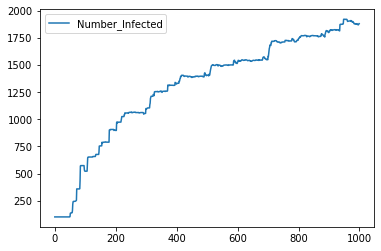

In [19]:
num_infected_overtime = model.datacollector.get_model_vars_dataframe()
num_infected_overtime.plot()

In [ ]:
density_threshold = 10
densities = [10, 20, 45, 23, 20, 50, 32, 17]
distances = [7,2,3,4,5,6,1,8]
min_distance = np.argmin(distances)
responsible = False
viable_patches = [i < density_threshold for i in densities]
# filtered_list = [i for (i, v) in zip(distances, viable_patches) if v ]
min_index = 0
if sum(viable_patches) > 0:
    for i in range(len(distances)):
        if viable_patches[i] ==  True and distances[i] < distances[min_index]:
            min_index = i;
    min_index
else:
    if responsible == True:
        min_index = np.argmin(densities)
    else:
        min_index = np.argmin(distances)
min_index
# new_pos = neighbors[min_index]
        
#         if len(low_density) > 0:
#             low_density 
#             new_position = neighbors[np.argmin(list_of_dist)]
#         sd_position = min(dictionary, key = dictionary.get)
#         self.model.grid.move_agent(self, sd_position)

In [ ]:
# model = CovidModel(10000, 1200, 1000)
# for i in range(20):
#     model.step()

In [ ]:
# import numpy as np
# agent_counts = np.zeros((model.grid.width, model.grid.height))
# for cell in model.grid.coord_iter():
#     cell_content, x, y = cell
#     agent_count = len(cell_content)
#     agent_counts[x][y] = agent_count
# plt.imshow(agent_counts,interpolation='nearest')
# plt.colorbar()

In [5]:
from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer

def agent_portrayal(agent):
    portrayal = {"Shape": "circle",
                 "Color": "red",
                 "Filled": "true",
                 "Layer": 0,
                 "r": 0.5}
    if agent.infected == 0:
        portrayal["Color"] = "blue"
        portrayal["Layer"] = 0
        portrayal["r"] = 0.5
    else:
        portrayal["Color"] = "red"
        portrayal["Layer"] = 1
        portrayal["r"] = 0.2
    return portrayal

grid = CanvasGrid(agent_portrayal, 100, 100, 1000, 1000)
server = ModularServer(CovidModel,
                       [grid],
                       "Covid Model",
                       {"N":4000, "width":100, "height":100,"initial_infected":100,
                        "p_mask":0.9, "p_responsible":0.9})
server.port = 8521 # The default
server.launch()

finished
Interface starting at http://127.0.0.1:8521


RuntimeError: This event loop is already running

Socket opened!
{"type":"reset"}
finished
{"type":"get_step","step":1}
{"type":"get_step","step":2}
{"type":"get_step","step":3}
{"type":"get_step","step":4}
{"type":"get_step","step":5}
{"type":"get_step","step":6}
{"type":"get_step","step":7}
{"type":"get_step","step":8}
{"type":"get_step","step":9}
{"type":"get_step","step":10}
{"type":"get_step","step":11}
{"type":"get_step","step":12}
{"type":"get_step","step":13}
{"type":"get_step","step":14}
{"type":"get_step","step":15}
{"type":"get_step","step":16}
{"type":"get_step","step":17}
{"type":"get_step","step":18}
{"type":"get_step","step":19}
{"type":"get_step","step":20}
{"type":"get_step","step":21}
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im

im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
{"type":"get_step","step":27}
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im

im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
{"type":"get_step","step":73}
im here
im here
im here
im here
im here
im here
im

im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


{"type":"get_step","step":106}
{"type":"get_step","step":107}
{"type":"get_step","step":108}
{"type":"get_step","step":109}
{"type":"get_step","step":110}
{"type":"get_step","step":111}
{"type":"get_step","step":112}
{"type":"get_step","step":113}
{"type":"get_step","step":114}
{"type":"get_step","step":115}
{"type":"get_step","step":116}
{"type":"get_step","step":117}
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im h

im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
{"type":"get_step","step":122}
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
i

im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
{"type":"get_step","step":125}
{"type":"get_step","step":126}
{"type":"get_step","step":127}
{"type":"get_step","step":128}
{"type":"get_step","step":129}
{"type":"get_step","step":130}
{"type":"get_step","step":131}
{"type":"get_step","step":132}
{"type":"get_step","step":133}
{"type":"get_step","step":134}
{"type":"get_step","step":135}
{"type":"get_step","step":136}
{"type":"get_step","step":137}
{"type":"get_step","step":138}
{"type":"get_step","step":139}
{"type":"get_step","step":140}
{"type":"get_step","step":141}
{"type":"get_step","step":142}
{"type":"get_step","step":143}
{"t

im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
{"type":"get_step","step":168}
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
i

im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here


im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
im here
